# Init the Spark session

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from os.path import abspath
import os

# SparkSession
URL_SPARK = "spark://spark-master:7077"
warehouse_location = './spark-warehouse'

spark = (
    SparkSession.builder
    .appName("spark-ml-multiVM")
    .config("executor.memory", "8g")
    .config("spark.sql.warehouse.dir", warehouse_location)
    .master(URL_SPARK)
    .getOrCreate()
)

/usr/local/lib/python3.9/dist-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/21 20:09:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data log of VM 1
- Note that this VM was a VM hosting my programs.

In [2]:
path = "./raw_data_VM_1/mon-vm.log"
df1 = spark.read.text(path)
df1.printSchema()

root
 |-- value: string (nullable = true)



In [3]:
from pyspark.sql.functions import *

df_1 = df1.withColumn('timestamp', regexp_extract('value', r'timestamp:\s(.*),\sused_memory', 1)) \
        .withColumn('cpu', regexp_extract('value', r'used_cpu:\s(.*)\%', 1)) \
        .withColumn('memory', regexp_extract('value', r'used_memory:\s(.*)\%\s+,\sused_storage', 1)) \
        .withColumn('storage', regexp_extract('value', r'used_storage:\s(.*)\%\s+,\sused_cpu', 1))

df_1 = df_1.drop('value')
df_1.printSchema()
df_1.count()

root
 |-- timestamp: string (nullable = true)
 |-- cpu: string (nullable = true)
 |-- memory: string (nullable = true)
 |-- storage: string (nullable = true)



18803

In [4]:
df_1.summary().show()

+-------+--------------------+-------------------+------------------+-----------------+
|summary|           timestamp|                cpu|            memory|          storage|
+-------+--------------------+-------------------+------------------+-----------------+
|  count|               18803|              18803|             18803|            18803|
|   mean|                null| 0.1728851778971414| 39.37673562729289|41.37637611019518|
| stddev|                null|0.17198840557713962|4.0126939020432015|5.834714976312954|
|    min|06-06-23 07:52:17 PM|               0.00|             20.92|               25|
|    25%|                null|               0.07|             35.72|             37.0|
|    50%|                null|               0.14|             41.78|             45.0|
|    75%|                null|               0.22|             42.54|             45.0|
|    max|21-06-23 12:59:12 AM|               3.13|             44.56|               46|
+-------+--------------------+--

In [5]:
spark.sql("CREATE DATABASE IF NOT EXISTS mondb")

DataFrame[]

In [7]:
df_1.write.mode('overwrite').saveAsTable("mondb.bronze_vmlog_acumos")

In [8]:
my_df = spark.sql('SELECT * FROM mondb.bronze_vmlog_acumos')

# Load data log of VM Maas-Controller

In [9]:
path2 = "./raw_data_VM_MaasController/mon-vm.log"
df2 = spark.read.text(path2)
df2.printSchema()

root
 |-- value: string (nullable = true)



In [10]:
df_maas_controller = df2.withColumn('timestamp', regexp_extract('value', r'timestamp:\s(.*),\sused_memory', 1)) \
        .withColumn('cpu', regexp_extract('value', r'used_cpu:\s(.*)\%', 1)) \
        .withColumn('memory', regexp_extract('value', r'used_memory:\s(.*)\%\s+,\sused_storage', 1)) \
        .withColumn('storage', regexp_extract('value', r'used_storage:\s(.*)\%\s+,\sused_cpu', 1))

df_maas_controller = df_maas_controller.drop('value')
df_maas_controller.printSchema()
df_maas_controller.count()

root
 |-- timestamp: string (nullable = true)
 |-- cpu: string (nullable = true)
 |-- memory: string (nullable = true)
 |-- storage: string (nullable = true)



2500

In [11]:
df_maas_controller.summary().show()

+-------+--------------------+-------------------+--------------------+-------+
|summary|           timestamp|                cpu|              memory|storage|
+-------+--------------------+-------------------+--------------------+-------+
|  count|                2500|               2500|                2500|   2500|
|   mean|                null|0.04114800000000018|  15.197000000000061|   86.0|
| stddev|                null|0.07814988840697848|0.048224581326311994|    0.0|
|    min|19-06-23 01:52:26 PM|               0.00|               15.12|     86|
|    25%|                null|                0.0|               15.16|   86.0|
|    50%|                null|               0.01|               15.18|   86.0|
|    75%|                null|               0.05|               15.22|   86.0|
|    max|21-06-23 12:59:44 AM|               0.97|               15.46|     86|
+-------+--------------------+-------------------+--------------------+-------+



In [13]:
df_maas_controller.write.mode('overwrite').saveAsTable("mondb.bronze_vmlog_maas_controller")

# Combine two time series into one multivariate time series

In [14]:
import pyspark
import pyspark.pandas as ps
import pandas as pd

#convert spark dataframe to pandas for more visualization
pd_df_vm1 =  df_1.toPandas()
pd_df_vm2 = df_maas_controller.toPandas() 

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/__init__.py:47: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [15]:
pd_df_vm1['timestamp'] = pd.to_datetime(pd_df_vm1['timestamp'],format='%d-%m-%y %I:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')
pd_df_vm1['timestamp'] = pd.to_datetime(pd_df_vm1['timestamp'])
pd_df_vm1.apply(pd.to_numeric, errors='ignore')
pd_df_vm1.set_index('timestamp',inplace=True)

In [16]:
pd_df_vm1['cpu'] = pd_df_vm1['cpu'].astype('float')
pd_df_vm1['memory'] = pd_df_vm1['memory'].astype('float')
pd_df_vm1['storage'] = pd_df_vm1['storage'].astype('float')

Text(0.5, 1.0, 'Workload Features VM1')

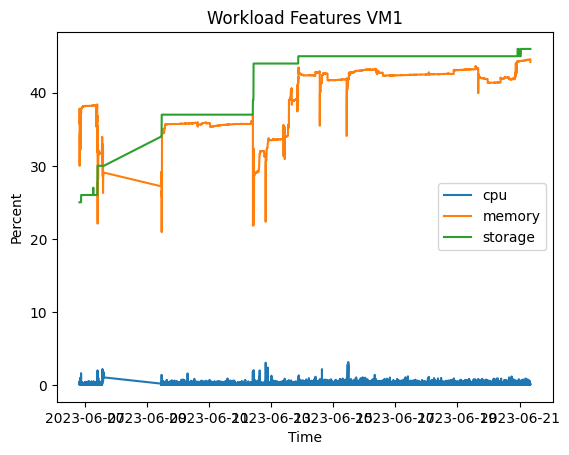

In [17]:
import matplotlib.pyplot as plt

plt.plot(pd_df_vm1['cpu'])
plt.plot(pd_df_vm1['memory'])
plt.plot(pd_df_vm1['storage'])
plt.xlabel('Time')
plt.ylabel('Percent')
plt.legend(['cpu','memory','storage'])
plt.title('Workload Features VM1')

In [18]:
pd_df_vm2['timestamp'] = pd.to_datetime(pd_df_vm2['timestamp'],format='%d-%m-%y %I:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')
pd_df_vm2['timestamp'] = pd.to_datetime(pd_df_vm2['timestamp'])
pd_df_vm2.apply(pd.to_numeric, errors='ignore')
pd_df_vm2.set_index('timestamp',inplace=True)
pd_df_vm2['cpu'] = pd_df_vm2['cpu'].astype('float')
pd_df_vm2['memory'] = pd_df_vm2['memory'].astype('float')
pd_df_vm2['storage'] = pd_df_vm2['storage'].astype('float')

In [19]:
pd_df_vm2.head()

,cpu,memory,storage
timestamp,,,
2023-06-19 13:52:26,0.00,15.18,86.0
2023-06-19 13:53:26,0.13,15.19,86.0
2023-06-19 13:54:26,0.05,15.19,86.0
2023-06-19 13:55:27,0.02,15.18,86.0
2023-06-19 13:56:27,0.00,15.19,86.0


Text(0.5, 1.0, 'Workload Features VM2')

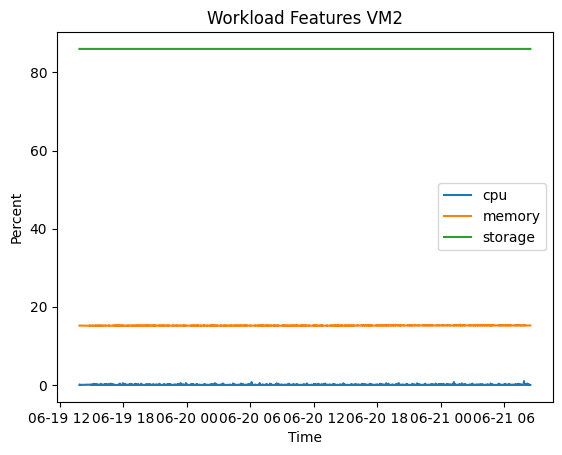

In [20]:
plt.plot(pd_df_vm2['cpu'])
plt.plot(pd_df_vm2['memory'])
plt.plot(pd_df_vm2['storage'])
plt.xlabel('Time')
plt.ylabel('Percent')
plt.legend(['cpu','memory','storage'])
plt.title('Workload Features VM2')

In [21]:
# rename columns of two dataframe since now they have the same column names
n_vm = 2
df_dict={}
df_dict['vm1'] = pd_df_vm1
df_dict['vm2'] = pd_df_vm2
for i in range(0,n_vm):
    df_dict['vm'+str(i+1)] = df_dict['vm'+str(i+1)].rename(columns={"cpu": "cpu_vm"+str(i+1), "memory": "memory_vm"+str(i+1),"storage": "storage_vm"+str(i+1)})

In [22]:
# join two time series using time stamp index union and sort the index of combined data frame according to time stamp
combined_df = df_dict['vm1'].join(df_dict['vm2'],how='outer')

In [23]:
combined_df

,cpu_vm1,memory_vm1,storage_vm1,cpu_vm2,memory_vm2,storage_vm2
timestamp,,,,,,
2023-06-06 19:52:17,0.12,36.06,25.0,NaN,NaN,NaN
2023-06-06 19:52:22,0.11,35.99,25.0,NaN,NaN,NaN
2023-06-06 19:52:27,0.10,35.99,25.0,NaN,NaN,NaN
2023-06-06 19:52:40,0.09,35.98,25.0,NaN,NaN,NaN
2023-06-06 19:52:45,0.07,35.98,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-06-21 08:24:00,NaN,NaN,NaN,0.02,15.21,86.0
2023-06-21 08:25:00,NaN,NaN,NaN,0.01,15.21,86.0
2023-06-21 08:26:00,NaN,NaN,NaN,0.00,15.19,86.0


# Convert pandas dataframe to spark dataframe

In [24]:
#convert index of pandas dataframe to a column
combined_df_ = combined_df.reset_index()
combined_df_.columns

Index(['timestamp', 'cpu_vm1', 'memory_vm1', 'storage_vm1', 'cpu_vm2',
       'memory_vm2', 'storage_vm2'],
      dtype='object')

In [25]:
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(combined_df_) 
sparkDF.printSchema()
sparkDF.show()
#store it to spark warehourse 
sparkDF.write.mode('overwrite').saveAsTable("mondb.bronze_vmlog_join")

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- timestamp: timestamp (nullable = true)
 |-- cpu_vm1: double (nullable = true)
 |-- memory_vm1: double (nullable = true)
 |-- storage_vm1: double (nullable = true)
 |-- cpu_vm2: double (nullable = true)
 |-- memory_vm2: double (nullable = true)
 |-- storage_vm2: double (nullable = true)



+-------------------+-------+----------+-----------+-------+----------+-----------+
|          timestamp|cpu_vm1|memory_vm1|storage_vm1|cpu_vm2|memory_vm2|storage_vm2|
+-------------------+-------+----------+-----------+-------+----------+-----------+
|2023-06-06 19:52:17|   0.12|     36.06|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:52:22|   0.11|     35.99|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:52:27|    0.1|     35.99|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:52:40|   0.09|     35.98|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:52:45|   0.07|     35.98|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:52:50|   0.07|     35.97|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:52:55|   0.06|     36.03|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:53:00|   0.06|     35.99|       25.0|    NaN|       NaN|        NaN|
|2023-06-06 19:53:06|   0.05|     35.99|       25.0|    NaN|       NaN|     

In [ ]:
exit()